### This script will make logo plots for each mAb against NiV

In [1]:
import math
import os
import re

import altair as alt

import numpy as np

import pandas as pd

import scipy.stats

import Bio.SeqIO

import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'

from Bio import PDB
#from Bio.PDB import PDBParser, NeighborSearch, Selection

import dmslogo
from dmslogo.colorschemes import CBPALETTE
from dmslogo.colorschemes import ValueToColorMap

In [2]:
# allow more rows for Altair
_ = alt.data_transformers.disable_max_rows()

if os.getcwd() == '/fh/fast/bloom_j/computational_notebooks/blarsen/2023/Nipah_Malaysia_RBP_DMS/':
    pass
    print("Already in correct directory")
else:
    os.chdir("/fh/fast/bloom_j/computational_notebooks/blarsen/2023/Nipah_Malaysia_RBP_DMS/")
    print("Setup in correct directory")

Setup in correct directory


### Load in altair theme

In [3]:
%run "notebooks/configs/theme.py"

In [4]:
func_scores_E3 = pd.read_csv('../Nipah_Malaysia_RBP_DMS/results/func_effects/averages/CHO_EFNB3_func_effects.csv')
func_scores_E2 = pd.read_csv('../Nipah_Malaysia_RBP_DMS/results/func_effects/averages/CHO_EFNB2_new_func_effects.csv')

In [5]:
merged_func_scores = pd.merge(func_scores_E2, func_scores_E3, on=['site','wildtype','mutant'],how='outer',suffixes=['_E2','_E3'])
merged_func_scores = merged_func_scores[
    (merged_func_scores['times_seen_E2'] >= 1) &
    (merged_func_scores['times_seen_E3'] >= 2) &
    #(merged_func_scores['effect_std_E2'] < 6) &
    #(merged_func_scores['effect_std_E3'] < 6) &
    (merged_func_scores['mutant'] != '*') &
    (merged_func_scores['mutant'] != '-')
]

display(merged_func_scores)

,site,wildtype,mutant,effect_E2,effect_std_E2,times_seen_E2,n_selections_E2,effect_E3,effect_std_E3,times_seen_E3,n_selections_E3
1,71,Q,A,-0.52410,1.01800,1.667,3.0,0.4558,0.22230,2.0,5.0
2,71,Q,C,-0.74020,0.52200,5.000,3.0,-0.4433,0.81840,3.8,5.0
3,71,Q,D,0.06477,0.85650,5.000,3.0,-0.3342,0.69510,4.6,5.0
4,71,Q,E,-0.37130,0.04515,5.000,3.0,-0.4527,0.88770,4.8,5.0
5,71,Q,F,-0.83080,0.64600,4.333,3.0,-0.5650,0.25090,3.4,5.0
...,...,...,...,...,...,...,...,...,...,...,...
10784,602,T,S,0.40860,0.10360,6.000,3.0,0.3223,0.25450,5.0,5.0
10786,602,T,V,0.45080,0.11630,6.667,3.0,0.4200,0.07688,5.6,5.0
10787,602,T,W,0.35870,0.04588,7.000,3.0,0.3664,0.20470,7.0,5.0
10788,602,T,Y,0.22890,0.15810,7.333,3.0,0.4637,0.17800,6.6,5.0


### Filter each antibody escape by times seen and functional score and save to a .csv for mapping colors onto structure. Also make logo plots

In [6]:
#here are filtering parameters
sums_threshold = 0.99 #will include top X% of summed escape sites
max_threshold = 0.99 #will include top X% of max escape sites
min_escape_cutoff = 0.3 #remove low antibody escape scores

antibody_times_seen = 3 #how many times a unique barcoded mutation was observed in antibody escape
functional_effect_cutoff = -4 #only antibody escape mutants above this functional score will be included


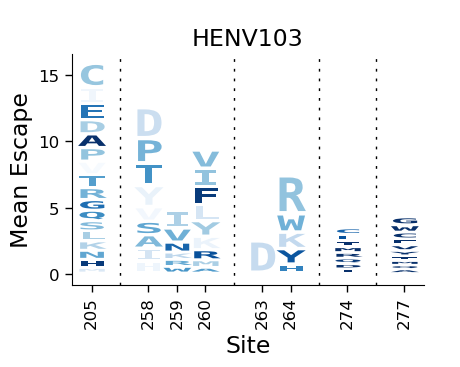

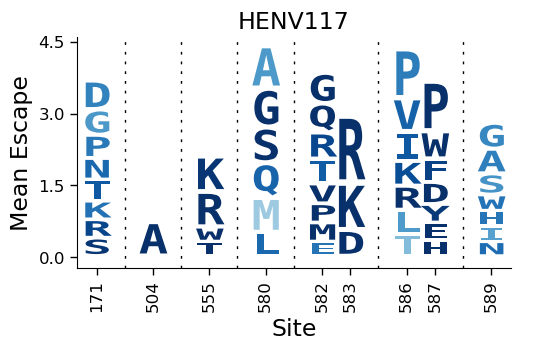

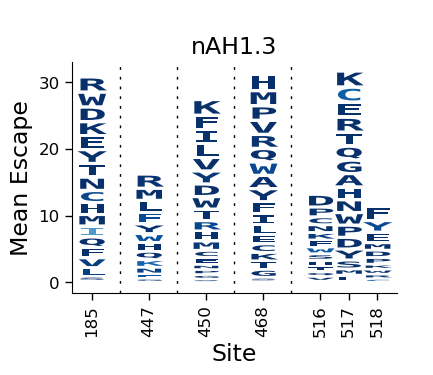

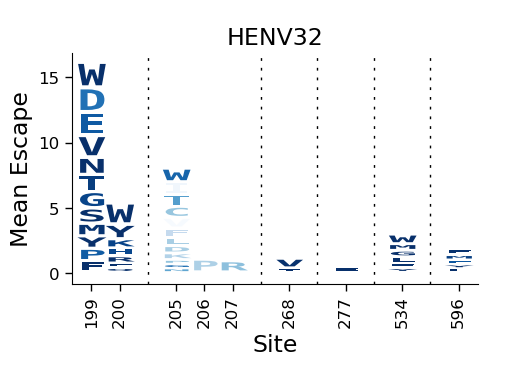

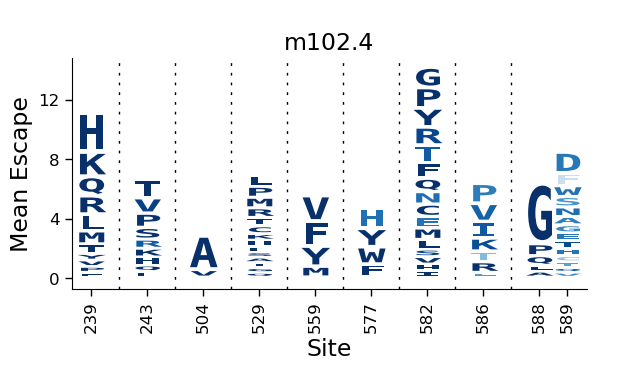

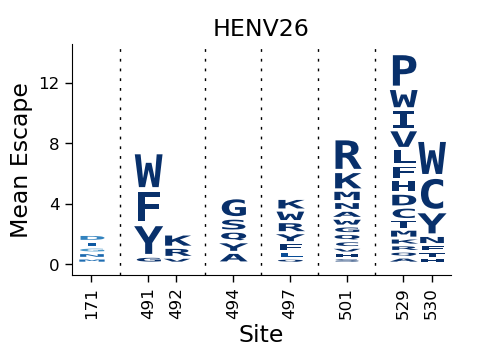

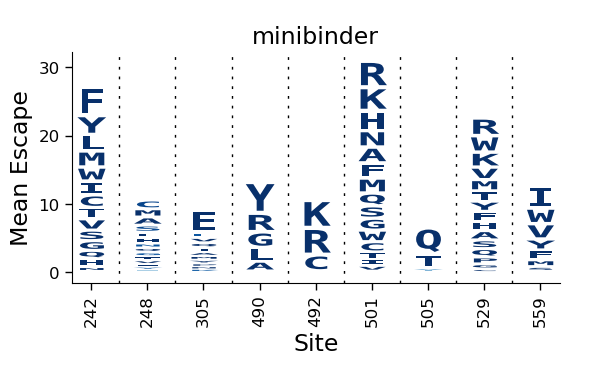

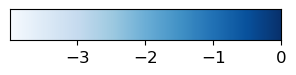

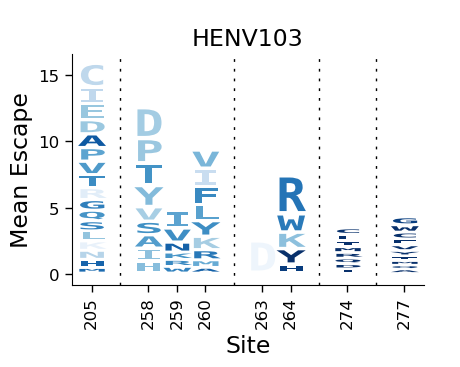

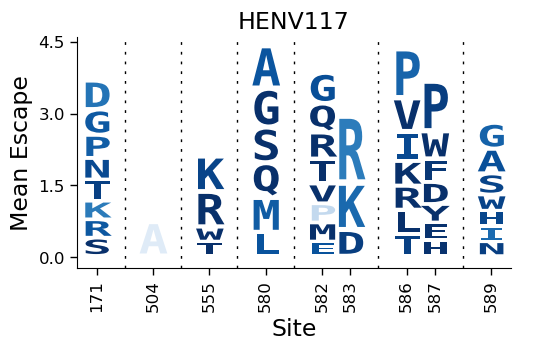

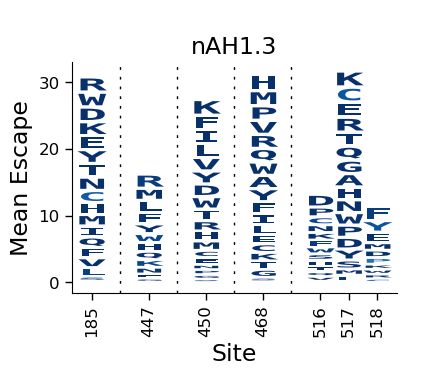

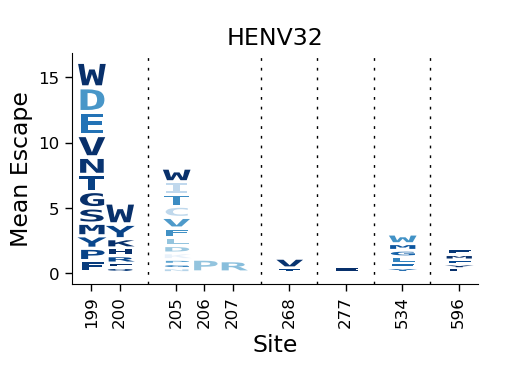

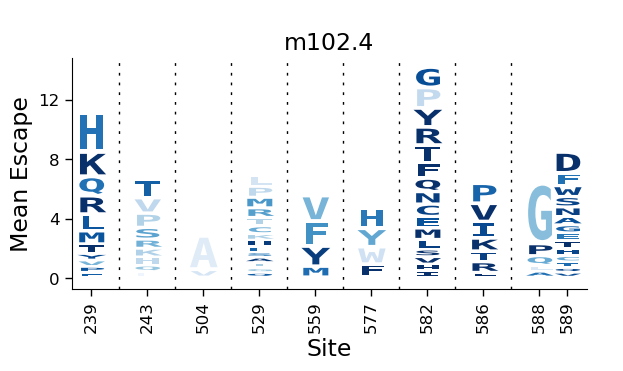

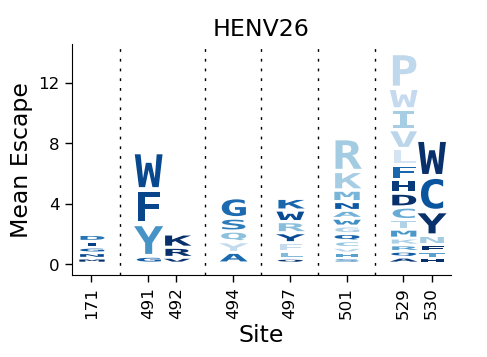

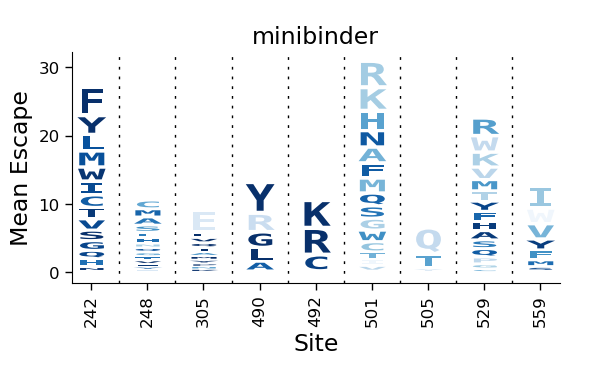

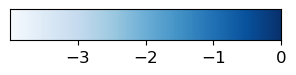

In [7]:
# Constants
OUTPUT_PATH = 'notebooks/outputs/filtered_escape_files/'
OUTPUT_BASE_PATH = 'notebooks/outputs/logo_plots/'
# Make sure the directories exist
os.makedirs(OUTPUT_PATH, exist_ok=True)

# For changing the name of the mAbs
FILE_MAP = {
    'HENV103_mut_effect.csv': 'HENV103',
    'HENV117_mut_effect.csv': 'HENV117',
    'nAH1.3_mut_effect.csv': 'nAH1.3',
    'HENV32_mut_effect.csv': 'HENV32',
    'm102.4_mut_effect.csv': 'm102.4',
    'HENV26_mut_effect.csv': 'HENV26',
    'minibinder_mut_effect.csv': 'Minibinder'
}


# Function for generating the logo plots
def generate_logo_plot(df, output_file, title):
    """Generate logo plot and save as a file."""
    fig, ax = dmslogo.draw_logo(
        data=df.query('show_site'),
        x_col='site',
        letter_col='mutant',
        letter_height_col='escape_mean',
        ylabel='Mean Escape',
        xlabel='Site',
        color_col='color',
        title=title
    )
    fig.savefig(output_file, bbox_inches='tight',format='svg')

# Empty name to hold the output of all mAb escape files concatonated together    
all_processed_dfs = {}

#I don't think I need this actually
dfs_filter_only = {}

def filter_escape_files(func_scores,title):
    escape_std_cutoff = 2 #only antibody escape mutants below this escape_std will be included
    folder_path = '../Nipah_Malaysia_RBP_DMS/results/antibody_escape/averages/'
    all_files = os.listdir(folder_path)
    
    # Get a list of each mAb escape .csv
    csv_files = [file for file in all_files if file.endswith('effect.csv')]
    # For loop to iterate through each mAb escape file
    for file in csv_files:
        # Add the title to the output filename
        output_file_path = os.path.join(OUTPUT_PATH, FILE_MAP[file] + '_' + title + '.csv')
        
        # Read in mAb Escape file
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        
        # Merge mAb escape file with functional_scores
        processed_df = df.merge(func_scores, on=['site','wildtype','mutant'],how='left',suffixes=['_ab','func_effects'])

        #filter data frames first
        processed_df = processed_df[
            (processed_df['mutant'] != '*') & #Get rid of stop codon mutants
            (processed_df['times_seen'] >= antibody_times_seen) & #Filter out mAb escape mutants with low observations
            (processed_df['frac_models'] == 1) & #Filter out mutants that are seen in only one model
            (processed_df['effect_E2'] >= functional_effect_cutoff) & 
            (processed_df['effect_E3'] >= functional_effect_cutoff) & 
            (processed_df['escape_std'] < escape_std_cutoff) & #Filter out mutants with low std deviations between replicates
            (processed_df['site'] != 603) #Filter out this site since its after the stop codon
        ]
        dfs_filter_only[file] = processed_df.copy()
        
        # Get sites with max score over some percentile threshold
        sums_max = processed_df.groupby('site')['escape_mean'].max()
        quantile_max = sums_max.quantile(max_threshold)
        sites_max_score = sums_max[sums_max > quantile_max].index.tolist()

        # Get sites with sum score over percentile threshold
        sums_total = processed_df.groupby('site')['escape_mean'].sum()
        quantile_total = sums_total.quantile(sums_threshold)
        sites_agg_sum = sums_total[sums_total > quantile_total].index.tolist()

        # Combine both lists of sites
        sites_to_show_list = list(set(sites_max_score + sites_agg_sum))
        # Add a column to data
        processed_df['show_site'] = processed_df['site'].isin(sites_to_show_list)

        # Save processed df of each mAb for mapping onto crystal structure
        processed_df.to_csv(output_file_path, index=False)

        # Color by functional score and clip scores > 0
        processed_df['clip'] = np.clip(processed_df[f'effect_{title}'], None, 0)
        min_prop = processed_df[f'effect_{title}'].min()
        max_prop = processed_df['clip'].max()

        map1 = ValueToColorMap(minvalue=min_prop, maxvalue=max_prop, cmap='Blues')
        processed_df['color'] = processed_df['clip'].map(map1.val_to_color)

        processed_df = processed_df[processed_df['escape_mean'] >= min_escape_cutoff]
        all_processed_dfs[file] = processed_df.copy()

        # Add the title to the output base filename for the logo plot
        if file in FILE_MAP:
            output_file = os.path.join(OUTPUT_BASE_PATH, FILE_MAP[file] + '_' + title + '.svg')
            generate_logo_plot(processed_df, output_file, file.replace('_mut_effect.csv', ''))
    
    # Add the title to the scalebar filename
    fig, _ = map1.scale_bar(orientation='horizontal')
    fig.savefig(os.path.join(OUTPUT_BASE_PATH, title + '_scalebar.svg'), bbox_inches='tight',format='svg')


filter_escape_files(merged_func_scores,'E2')
filter_escape_files(merged_func_scores,'E3')

### Now Process the filtered data frames from above to combine all the mAb data frames into one

In [8]:
# Function for filtering out sites that are in the top escape as calculated above
def filter_and_label_dfs(df):
    filtered_dfs = []

    # Filter and label each dataframe based on its source
    for key, df in df.items():
        filtered_df = df[df['show_site']].copy()  # Filter by 'show_site' column
        filtered_df['source'] = key  # Add a column indicating the source
        filtered_dfs.append(filtered_df)

    # Combine all dataframes
    combined_df = pd.concat(filtered_dfs, ignore_index=True)
    
    # Filter out specific entries
    combined_df = combined_df[combined_df['source'] != 'minibinder_mut_effect.csv']

    # Map source names to custom labels
    custom_labels = {
        'HENV103_mut_effect.csv': 'HENV-103',
        'HENV117_mut_effect.csv': 'HENV-117',
        'nAH1.3_mut_effect.csv': 'nAH1.3',
        'HENV32_mut_effect.csv': 'HENV-32',
        'm102.4_mut_effect.csv': 'm102.4',
        'HENV26_mut_effect.csv': 'HENV-26'
    }
    combined_df['ab'] = combined_df['source'].map(lambda x: custom_labels.get(x, x))
    
    cols_to_drop = [col for col in combined_df.columns if "LibA-" in col or "LibB-" in col or "n_selection" in col or "clip" in col or "color" in col or "show_site" in col or "source" in col or "model" in col]

    # Now, drop these columns from the dataframe
    combined_df = combined_df.drop(columns=cols_to_drop)

    
    return combined_df
df_filter = filter_and_label_dfs(all_processed_dfs)

In [9]:
df_filter.query('site == 559')

,epitope,site,wildtype,mutant,mutation,escape_mean,escape_median,escape_std,times_seen,effect_E2,effect_std_E2,times_seen_E2,effect_E3,effect_std_E3,times_seen_E3,ab
303,1,559,Q,F,Q559F,1.6650,1.6650,0.3550,6.500,0.4303,0.11690,6.000,-1.4930,0.7223,7.2,m102.4
304,1,559,Q,M,Q559M,0.7143,0.7143,0.1127,4.000,0.2905,0.11570,3.000,-0.9413,0.9619,4.4,m102.4
305,1,559,Q,V,Q559V,1.7360,1.7360,0.2113,5.667,0.4783,0.13930,10.670,-2.1230,0.7569,8.2,m102.4
306,1,559,Q,Y,Q559Y,1.3630,1.3630,0.3299,5.500,0.4625,0.07551,4.333,-0.2072,0.1833,5.4,m102.4


### Same function as above, but don't filter the df based on show_site so that all antibody escape gets kept

In [10]:
# Function for combining ALL antibody escape sites
def label_dfs(df):
    filtered_dfs = []

    # Filter and label each dataframe based on its source
    for key, df in df.items():
        filtered_df = df.copy()  # Filter by 'show_site' column
        filtered_df['source'] = key  # Add a column indicating the source
        filtered_dfs.append(filtered_df)

    # Combine all dataframes
    combined_df = pd.concat(filtered_dfs, ignore_index=True)
    
    # Filter out specific entries
    combined_df = combined_df[combined_df['source'] != 'minibinder_mut_effect.csv']

    # Map source names to custom labels
    custom_labels = {
        'HENV103_mut_effect.csv': 'HENV-103',
        'HENV117_mut_effect.csv': 'HENV-117',
        'nAH1.3_mut_effect.csv': 'nAH1.3',
        'HENV32_mut_effect.csv': 'HENV-32',
        'm102.4_mut_effect.csv': 'm102.4',
        'HENV26_mut_effect.csv': 'HENV-26'
    }
    combined_df['ab'] = combined_df['source'].map(lambda x: custom_labels.get(x, x))
    
    return combined_df
df_total = label_dfs(dfs_filter_only)

### Now we have two data frames. df_filter only contains subset of escape scores meeting criteria. df_total contains everything.

In [11]:
# Now I have two data frames containing information
display(df_filter.head(2)) # filter_df contains the filtered sites that match 'show_site' as identified as top escape sites
display(df_total.head(2)) #df_total contains all escape and functional scores

,epitope,site,wildtype,mutant,mutation,escape_mean,escape_median,escape_std,times_seen,effect_E2,effect_std_E2,times_seen_E2,effect_E3,effect_std_E3,times_seen_E3,ab
0,1,205,Y,A,Y205A,1.034,1.034,0.1144,7.500,-0.00341,0.9442,9.333,-0.627,0.7602,7.2,HENV-103
1,1,205,Y,C,Y205C,1.826,1.826,0.4525,5.167,-2.42500,0.8099,6.667,-2.916,0.2486,9.0,HENV-103


,epitope,site,wildtype,mutant,mutation,escape_mean,escape_median,escape_std,n_models,times_seen,...,LibB-230720-HENV32,LibB-230907-HENV32,LibA-230725-m102.4,LibB-230720-m102.4,LibA-231024-HENV26,LibB-230818-HENV26,LibB-230907-HENV26,LibA-230812-minibinder,LibB-230907-minibinder,ab
0,1,71,Q,D,Q71D,-0.02163,-0.02163,0.09397,2,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HENV-103
1,1,71,Q,E,Q71E,-0.12840,-0.12840,0.13590,2,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HENV-103


### Plot bubble chart showing mAb escape for individual mutants by functional score for both E2 or E3

In [12]:
order_ab = ['m102.4','HENV-26','HENV-117','HENV-103','HENV-32','nAH1.3']
def generate_chart(df,metric):
    variant_selector = alt.selection_point(
    on="mouseover",
    empty=False,
    fields=["site"],
    value=1
    )
    
    chart = alt.Chart(df).mark_point(filled=True, opacity=0.4).encode(
        x=alt.X('ab:O',sort=order_ab, title='Antibody', axis=alt.Axis(labelAngle=-45,grid=True)),
        y=alt.Y(f'effect_{metric}:Q', title=f'Cell Entry of Top Escape Mutants ({metric})', axis=alt.Axis(grid=True, tickCount=4)),
        size=alt.Size('escape_mean', legend=alt.Legend(title='Mean Escape By Mutation')),
        xOffset='random:Q',
        tooltip=['site','wildtype','mutant','ab', 'effect_E2','effect_E3', 'escape_mean','escape_std'],
        color=alt.Color('ab').legend(None),
        opacity=alt.condition(variant_selector, alt.value(1), alt.value(0.4)),
        strokeWidth=alt.condition(variant_selector,alt.value(2),alt.value(0))
    ).transform_calculate(
        random="sqrt(-1*log(random()))*cos(2*PI*random())"
        #random='random'
    ).properties(
        height=400,
        width=400
    ).add_params(variant_selector)

    return chart.display()

# Main code execution

generate_chart(df_filter,'E2')
generate_chart(df_filter,'E3')

alt.Chart(...)

alt.Chart(...)

### Now show same data but in boxplot form

In [13]:
def plot_escape_boxplot(df,metric):
    boxplots = alt.Chart(df).mark_boxplot(extent='min-max').encode(
        x=alt.X('ab:O', sort=order_ab, title='Antibody',axis=alt.Axis(labelAngle=-45,grid=False)),  # no title to avoid repetition
        y=alt.Y(f'effect_{metric}:Q',title=f'Cell Entry of Top Escape Mutants ({metric})',axis=alt.Axis(grid=True,tickCount=4)),
        size=alt.value(20),
        color=alt.Color('ab').legend(None)
    ).properties(
        height=400,
        width= 400
    )
    
    return boxplots.display()

plot_escape_boxplot(df_filter,'E2')
plot_escape_boxplot(df_filter,'E3')

alt.Chart(...)

alt.Chart(...)

### Now plot aggregated (mean) escape and functional scores

In [14]:
def apply_aggr(df,receptor, metric):
    escape_agg = getattr(df.groupby(['site','ab'])['escape_mean'], metric)
    means_escape = escape_agg().reset_index()
    
    entry_agg = getattr(df.groupby(['site','ab'])[f'effect_{receptor}'], metric)
    means_entry = entry_agg().reset_index()

    df_sum = pd.merge(means_escape,means_entry,on=['site','ab'],how='left')
    
    # Define a mask to get the 99th percentile value for each 'ab'
    top_1_percent_mask = df_sum['escape_mean'] >= df_sum.groupby('ab')['escape_mean'].transform(lambda x: x.quantile(0.95))

    # Use the mask to filter the DataFrame
    df_filtered = df_sum[top_1_percent_mask]

    # Now Make Chart
    chart = alt.Chart(df_filtered).mark_point(filled=True, opacity=0.5).encode(
            x=alt.X('ab:O',sort=order_ab, title='Antibody', axis=alt.Axis(labelAngle=-45,grid=True)),
            y=alt.Y(f'effect_{receptor}:Q', title=f'Mean Cell Entry at Top Sites ({receptor})',axis=alt.Axis(grid=True)),
            size=alt.Size('escape_mean', legend=alt.Legend(title='Mean Escape at Top Sites')),
            #xOffset='random:Q',
            tooltip=['site','ab','escape_mean',f'effect_{receptor}'],
            color=alt.Color('ab').legend(None),
        ).transform_calculate(
            #random="sqrt(-1*log(random()))*cos(2*PI*random())"
        ).properties(
            height=400,
            width=200
        )
    return chart.display()
    
apply_aggr(df_total,'E2','mean')
apply_aggr(df_total,'E3','mean')

alt.Chart(...)

alt.Chart(...)

### Plot only the top escape mutant at each site along with functional score

In [15]:
def plot_max_escape(df,receptor):
    idx = df.groupby(['site', 'ab'])['escape_mean'].idxmax()
    df_max_values = df.loc[idx]
    
    # Define a mask to get the 99th percentile value for each 'ab'
    top_1_percent_mask = df_max_values['escape_mean'] >= df_max_values.groupby('ab')['escape_mean'].transform(lambda x: x.quantile(0.98))

    # Use the mask to filter the DataFrame
    df_filtered = df_max_values[top_1_percent_mask]

    chart = alt.Chart(df_filtered).mark_point(filled=True, opacity=0.5).encode(
            x=alt.X('ab:O',sort=order_ab, title='Antibody', axis=alt.Axis(labelAngle=-45,grid=True)),
            y=alt.Y(f'effect_{receptor}:Q', title=f'Cell Entry of Top Escape Mutant ({receptor})',axis=alt.Axis(grid=True)),
            size=alt.Size('escape_mean', legend=alt.Legend(title='Escape of Top Escape Mutant')),
            #xOffset='random:Q',
            tooltip=['site','ab','escape_mean','effect_E2'],
            color=alt.Color('ab').legend(None),
        ).transform_calculate(
            #random="sqrt(-1*log(random()))*cos(2*PI*random())"
        ).properties(
            height=400,
            width=200
        )
    return chart.display()
    
# Combine the two charts


plot_max_escape(df_total,'E2')
plot_max_escape(df_total,'E3')

alt.Chart(...)

alt.Chart(...)

### Now summarize by number of mutations between wildtype and mutant codons

In [16]:
# Load in wt nucleotide sequence (which is different than the 'wt' sequence from Library as it was codon optimized)
wt_nucleotide_sequence = str(Bio.SeqIO.read('notebooks/data/alignments/wild_type_seq.fasta', 'fasta').seq)

codon_table = {
    "ATA":"I", "ATC":"I", "ATT":"I", "ATG":"M",
    "ACA":"T", "ACC":"T", "ACG":"T", "ACT":"T",
    "AAC":"N", "AAT":"N", "AAA":"K", "AAG":"K",
    "AGC":"S", "AGT":"S", "AGA":"R", "AGG":"R",
    "CTA":"L", "CTC":"L", "CTG":"L", "CTT":"L",
    "CCA":"P", "CCC":"P", "CCG":"P", "CCT":"P",
    "CAC":"H", "CAT":"H", "CAA":"Q", "CAG":"Q",
    "CGA":"R", "CGC":"R", "CGG":"R", "CGT":"R",
    "GTA":"V", "GTC":"V", "GTG":"V", "GTT":"V",
    "GCA":"A", "GCC":"A", "GCG":"A", "GCT":"A",
    "GAC":"D", "GAT":"D", "GAA":"E", "GAG":"E",
    "GGA":"G", "GGC":"G", "GGG":"G", "GGT":"G",
    "TCA":"S", "TCC":"S", "TCG":"S", "TCT":"S",
    "TTC":"F", "TTT":"F", "TTA":"L", "TTG":"L",
    "TAC":"Y", "TAT":"Y", "TAA":"*", "TAG":"*",
    "TGC":"C", "TGT":"C", "TGA":"*", "TGG":"W"
}

def find_closest_codon(wt_codon, mutant_aa):
    mutant_codons = [codon for codon, aa in codon_table.items() if aa == mutant_aa]
    min_mutations = 3  # Maximum mutations possible
    closest_codon = None
    for m_codon in mutant_codons:
        mutations = sum([1 for c1, c2 in zip(wt_codon, m_codon) if c1 != c2])
        if mutations < min_mutations:
            min_mutations = mutations
            closest_codon = m_codon
    return closest_codon, min_mutations

# Function to extract codon for a given site
def extract_codon(site):
    idx = (site - 1) * 3  # Now, it's straightforward: 0-based index for codon position.
    return wt_nucleotide_sequence[idx: idx + 3]

def apply_codon_to_df(df):
    df['wt_codon'] = df['site'].apply(extract_codon)
    df['closest_mutant_codon'] = df.apply(lambda row: find_closest_codon(row['wt_codon'], row['mutant'])[0], axis=1)
    df['min_mutations'] = df.apply(lambda row: find_closest_codon(row['wt_codon'], row['mutant'])[1], axis=1)
    return df

df_filter = apply_codon_to_df(df_filter)
df_total = apply_codon_to_df(df_total)



In [17]:
display(df_filter.columns)

Index(['epitope', 'site', 'wildtype', 'mutant', 'mutation', 'escape_mean',
       'escape_median', 'escape_std', 'times_seen', 'effect_E2',
       'effect_std_E2', 'times_seen_E2', 'effect_E3', 'effect_std_E3',
       'times_seen_E3', 'ab', 'wt_codon', 'closest_mutant_codon',
       'min_mutations'],
      dtype='object')

In [18]:
def plot_escape_and_mutations_away(df,receptor):
    #df = df[df['min_mutations'] == 1]
    chart = alt.Chart(df).mark_point(filled=True,opacity=0.5).encode(
        x=alt.X('min_mutations:N',title=None,axis=alt.Axis(grid=True)),
        y=alt.Y(f'effect_{receptor}:Q', title=f'Cell Entry of Escape Mutants ({receptor})',axis=alt.Axis(grid=True,tickCount=4)),   # 'Q' denotes a quantitative variable
        size=alt.Size('escape_mean',legend=alt.Legend(title='Escape of Mutant')),
        xOffset='random:Q',
        tooltip=['ab','effect_E2','escape_median','escape_mean','site','mutant'],
        color=alt.Color('ab:N').legend(None),
        column=alt.Column('ab',title=None,sort=order_ab,header=alt.Header(labelFontSize=18,labelFont='Helvetica Light'))
    ).transform_calculate(
        #random='random()'
        random="sqrt(-2*log(random()))*cos(2*PI*random())"
    ).properties(
        height=300,
        width=100
    )
    return chart.display()

plot_escape_and_mutations_away(df_filter,'E2')
plot_escape_and_mutations_away(df_filter,'E3')

alt.Chart(...)

alt.Chart(...)

### Now calculate distances between escape sites and closest amino acid in heavy and light chains

In [ ]:
def calculate_min_distances(pdb_path, source_chain_id, target_chain_ids, name):
    # Initialize the PDB parser and load the structure
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure('structure_id', pdb_path)

    source_chain = structure[0][source_chain_id]
    target_chains = [structure[0][chain_id] for chain_id in target_chain_ids]

    data = []

    for residueA in source_chain:
        if residueA.resname in ["HOH", "WAT", "IPA", "NAG"]:
            continue

        min_distance = float('inf')
        closest_residueB = None
        closest_chain_id = None
        residues_within_4 = 0

        for target_chain in target_chains:
            for residueB in target_chain:
                if residueB.resname in ["HOH", "WAT", "IPA"]:
                    continue

                # Check for residues within 4 angstroms
                is_within_4 = False
                for atomA in residueA:
                    for atomB in residueB:
                        distance = atomA - atomB
                        if distance < min_distance:
                            min_distance = distance
                            closest_residueB = residueB
                            closest_chain_id = target_chain.get_id()
                        if distance < 4:
                            is_within_4 = True
                if is_within_4:
                    residues_within_4 += 1

        data.append({
            'wildtype': residueA.resname,
            'site': residueA.id[1],
            'chain': closest_chain_id,
            'residue': closest_residueB.id[1],
            'residue_name': closest_residueB.resname,
            'distance': min_distance,
            'residues_within_4': residues_within_4,
            'ab': name
        })

    # Convert data to pandas DataFrame
    df = pd.DataFrame(data)
    return df

# Usage
pdb_path_26 = '../scripts/new_pipe_analyses/pdb/6vy5.pdb'
source_chain_26 = 'A'
target_chains_26 = ['H', 'L']

pdb_path_32 = '../scripts/new_pipe_analyses/pdb/6vy4.pdb'
source_chain_32 = 'A'
target_chains_32 = ['H', 'L']

pdb_path_nah = '../scripts/new_pipe_analyses/pdb/7txz.pdb'
source_chain_nah = 'A'
target_chains_nah = ['F', 'E']

pdb_path_m102 = '../scripts/new_pipe_analyses/pdb/6cmg.pdb'
source_chain_m102 = 'A'
target_chains_m102 = ['B', 'C']



df_HENV26 = calculate_min_distances(pdb_path_26, source_chain_26, target_chains_26, 'HENV-26')
display(df_HENV26)
df_HENV32 = calculate_min_distances(pdb_path_32, source_chain_32, target_chains_32, 'HENV-32')
display(df_HENV32)
df_nah = calculate_min_distances(pdb_path_nah, source_chain_nah, target_chains_nah, 'nAH1.3')
df_nah['chain'].replace({'E': 'H', 'F': 'L'}, inplace=True)
display(df_nah)
df_m102 = calculate_min_distances(pdb_path_m102, source_chain_m102, target_chains_m102, 'm102.4')
df_m102['chain'].replace({'C': 'H', 'B': 'L'}, inplace=True)
display(df_m102)
print('all done!')


In [ ]:
combined_distances = pd.concat([df_HENV26,df_HENV32,df_nah,df_m102],ignore_index=True)
combined = df_total.merge(combined_distances,on=['site','ab'],how='left')

In [ ]:
combined['color'] = combined['escape_mean'].apply(lambda val: 'Value' if pd.notna(val) else 'NaN')

chart = alt.Chart(combined).mark_point(filled=True,opacity=0.4,size=100).encode(
    x=alt.X('site:Q',title='Antibody',axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('distance:Q', title='Functional Effect of Escape Mutants',axis=alt.Axis(grid=False,tickCount=4)),   # 'Q' denotes a quantitative variable
    #size=alt.Size('distance',legend=alt.Legend(title='Mean Escape By Mutation')),
    #xOffset='random:Q',
    tooltip=['ab','effect_E2','escape_mean','site','mutant','chain'],
    color=alt.Color('chain').legend(None)
).transform_calculate(
    #random="sqrt(-0.00000001*log(random()))*cos(2*PI*random())"
).properties(
    #title='Functional Effects of Top Escape for each mAb',
    height=400,
    width=400
).facet(
    facet='ab'
)

chart

In [ ]:
def calculate_distance_mean(df):
    conditions = [
        (df['distance'] < 4),
        (df['distance'] >= 4) & (df['distance'] <= 8),
        (df['distance'] > 8)
    ]
    # Define the choices
    choices = ['contact', 'near', 'distal']

    # Create the new column
    df['distance_category'] = np.select(conditions, choices, default=np.nan)
    
    mean_values = df_total.groupby(['ab','site'])['escape_mean'].mean().reset_index()
    df = df.merge(mean_values, on=['ab','site'],how='left')
    
    return df
    
df_mean = calculate_distance_mean(combined_distances)


def calculate_distance(df):
    conditions = [
        (df['distance'] < 4),
        (df['distance'] >= 4) & (df['distance'] <= 8),
        (df['distance'] > 8)
    ]
    # Define the choices
    choices = ['contact', 'near', 'distal']

    # Create the new column
    df['distance_category'] = np.select(conditions, choices, default=np.nan)
    
    df = df_total.merge(df, on=['ab','site'],how='left')
    
    return df

df = calculate_distance(combined_distances)

display(df_mean.head(3))
display(df.head(3))

In [ ]:
def escape_by_distance_mean(df):
    chart = alt.Chart(df.query('escape_mean > 0')).mark_point(size=50,filled=True,opacity=0.4).encode(
    x=alt.X('residues_within_4:N',title='mAb residues < 4A away'),
    y=alt.Y('escape_mean:Q', title='Mean Escape'),
    xOffset='random:Q',
    #tooltip=['ab','escape_mean','site','mutant','chain','wildtype','residues_within_4'],
    #color=alt.Color('ab:N'),
    column=alt.Column('ab',title=None,header=alt.Header(labelFontSize=20,labelFont='Helvetica Light'))
    ).transform_calculate(
        random="sqrt(-0.00000001*log(random()))*cos(2*PI*random())"
    ).properties(
        #title='Functional Effects of Top Escape for each mAb',
        height=alt.Step(75),
        width=200
    )
    return chart.display()

escape_by_distance_mean(df)

In [ ]:
def escape_by_distance(df):
    order_distance = ['contact','near','distal']
    chart = alt.Chart(df).mark_circle().encode(
        x=alt.X('distance_category:N',sort=order_distance,title=None),
        y=alt.Y('escape_mean:Q', title='Mean Escape'),  # 'Q' denotes a quantitative variable
        xOffset='random:Q',
        tooltip=['ab','escape_mean','site'],
        color=alt.Color('distance_category:N',legend=None),
        column=alt.Column('ab',title=None,header=alt.Header(labelFontSize=20,labelFont='Helvetica Light'))
        ).transform_calculate(
        random="sqrt(-0.00000001*log(random()))*cos(2*PI*random())"
        ).properties(
            height=200,
            width=200
        )
    return chart.display()

escape_by_distance(df_mean)

In [ ]:
def escape_by_distance_all(df):
    df = df.dropna(subset=['distance_category'])
    order_distance = ['contact','near','distal']
    chart = alt.Chart(df).mark_circle(opacity=0.4).encode(
        x=alt.X('distance_category:N',sort=order_distance,title=None),
        y=alt.Y('escape_mean:Q', title='Escape'),  # 'Q' denotes a quantitative variable
        xOffset='random:Q',
        tooltip=['ab','escape_mean','site'],
        #color=alt.Color('chain:N'),
        column=alt.Column('ab',title=None,header=alt.Header(labelFontSize=20,labelFont='Helvetica Light'))
        ).transform_calculate(
        random="sqrt(-0.00000001*log(random()))*cos(2*PI*random())"
        ).properties(
            height=200,
            width=200
        )
    return chart.display()

escape_by_distance_all(df)

In [ ]:
def escape_by_distance(df):
    variant_selector = alt.selection_point(
    on="mouseover",
    empty=False,
    fields=["site"],
    value=1
    )
    
    chart = alt.Chart(df).mark_point(size=70,filled=True,opacity=0.4,stroke='black').encode(
    x=alt.X('residues_within_4:N',title='mAb residues < 4A away'),
    y=alt.Y('escape_mean:Q', title='Mean Escape'),
    xOffset='random:Q',
    tooltip=['ab','escape_mean','site','distance'],
    #color=alt.Color('min_mutations:N'),
    column=alt.Column('ab',title=None,header=alt.Header(labelFontSize=20,labelFont='Helvetica Light')),
    opacity=alt.condition(variant_selector, alt.value(1), alt.value(0.4)),
    strokeWidth=alt.condition(variant_selector,alt.value(2),alt.value(0))
    ).transform_calculate(
        random="sqrt(-0.00000001*log(random()))*cos(2*PI*random())"
    ).properties(
        #title='Functional Effects of Top Escape for each mAb',
        height=200,
        width=200
    ).add_params(variant_selector)
    return chart.display()

escape_by_distance(df)